In [1]:
#defining the classes Package, Bin and Student

class Package:
    def __init__(self, id, bin, location_in_bin, size, student):
        self.id = id
        self.size = size
        self.student = student  #student object
        self.letter = student.lastname_letter
        self.bin = bin
        self.location_in_bin = location_in_bin
        self.days_on_shelf = 0
        
    def getID(self):
        return self.id

    def getSize(self):
        return self.size
    
    def getLetter(self):
        return self.letter
    
    def getBin(self):
        return self.bin

    def getStudent(self):
        return self.student

    def getLocation(self):
        return self.location_in_bin

    def getDaysOnShelf(self):
        return self.days_on_shelf;

    def addDay(self):
        self.days_on_shelf = self.days_on_shelf+1

    # going to be used to modify Package when something is removed from its bin
    def setLocation(self, value):
        self.location_in_bin = value
    
    def __str__(self):
        return f"packageID: {self.id} {self.letter} | size = {self.size} | bin = {self.bin}, position {self.location_in_bin}"

    
class Bin:
    def __init__(self,label):
        self.label = label
        self.packages = []
    
    def addPackage(self,package):
        self.packages.append(package)
    
    def removePackage(self,package):
        self.packages.remove(package)

    def getLabel(self):
        return self.label
    
    def getPackages(self):
        return self.packages

    def getNumPackages(self):
        return len(self.packages)

    def __str__(self):
        return f"binID: {self.label}"

class Student: 
    def __init__(self,id,lastname_letter):
        self.id = id
        self.lastname_letter = lastname_letter.upper()

    def getID(self):
        return self.id

    def getLetter(self):
        return self.lastname_letter
        
    def __str__(self):
        return f"studentID: {self.id} | {self.lastname_letter}"

In [17]:
import pandas as pd
import numpy as np
import random as random
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv('lastnames.csv')
df['Percentage'] = df['Percentage']*0.01
total_probability = df['Percentage'].sum()
df ["Probability"] = df['Percentage']/total_probability
lastname_distribution = df[['Letter','Probability']]
lastname_distribution.head()

,Letter,Probability
0,M,0.096154
1,S,0.094151
2,B,0.085136
3,C,0.077123
4,H,0.071114


In [3]:
def select_lastname_based_on_distribution(df):
    rand_val = random.random()
    cumulative_prob = 0
    for index, row in df.iterrows():
        cumulative_prob += row['Probability']
        if rand_val <= cumulative_prob:
            return row['Letter']

## last name sim

In [4]:
pickup_dist = pd.read_csv('pickup_dist.csv')
arrival_counts_edited = pd.read_csv('arrival_counts_edited.csv')

In [30]:
def runLastNameSimulation2(packagesize_dist, lastname_dist, num_bins, arrival_counts_edited, pickup_dist, days):
    # for now, packagesize_dist is not implemented.

    #setup bins
    all_bins = [] #to store all the bins of this simulation
    #splits the alphabet into bins
    alpha_bin_names = np.array_split(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), num_bins)
    #creates bins based on alphabet
    for name in alpha_bin_names:
       all_bins.append(Bin(str(name)))
    
    all_packages = [] #to store all the packages of this simulation
    all_students = [] #to store all the students of this simulation
    counter_packages = 0 # for packageID purposes
    counter_students = 0 #for studentID purposes

    #VARIBLES WE WANT TO TRACK IN THE SIMULATION WILL GO IN THIS:
    df = pd.DataFrame(columns=['day', 'studentID', 'packageID', 'rackTime', 'findTime', 'totalTime', 'days_to_pickup'])
    df_total_packages = pd.DataFrame(columns = ['day', 'num_packages', 'packages_expired'])

    for d in range(days):
        # print("day ", d)
        num_packages=  arrival_counts_edited.loc[d]['count']
        for i in range(num_packages):
            #randomly get the lastnameletter from the distribution 
            letter = select_lastname_based_on_distribution(lastname_dist)

            #make the student 
            all_students.append(Student(counter_students, letter))
            counter_students= counter_students + 1 #increase counter, so that the next student has a unique id 


            #determine which bin it goes in
            for j in range(num_bins):
                if letter in alpha_bin_names[j]:
                    bin_to_go_in = j #this returns the bin's index number in the all_bins list 
    
            #finally, make the package object
            package = (Package(counter_packages, bin_to_go_in, all_bins[bin_to_go_in].getNumPackages(), 'small', all_students[i]))
            all_packages.append(package)
            counter_packages= counter_packages + 1 #increase counter, so that the next package has a unique id 
            
            #update the bin so it knows it has a new package
            all_bins[bin_to_go_in].addPackage(package)

        #print where the packages were assigned to!
        # for p in all_packages:
        #     print(p)

        # for s in all_students:
        #     print(s)
                
        # --------------------------------------------------------------------------
        #BEGIN THE SIMULATION
        
        # there is some probability that a student comes to pick up their package today 
        
        # GEOMETRIC VERSION 
        # packages_picked_up_today = []
        # for package in all_packages:
        #     randomvar = random.random()
        #     if (randomvar <= ((1-geo_prob)**(package.getDaysOnShelf()-1))*geo_prob):
        #         packages_picked_up_today.append(package)

        # DISTRIBUTION VERSION
        packages_picked_up_today = []
        for package in all_packages:
            randomvar = random.random()
            prob_of_pickup = pickup_dist.loc[package.getDaysOnShelf()]['count']
            if (randomvar <= prob_of_pickup):
                packages_picked_up_today.append(package)

        #shuffle the packages being picked up today 
        random.shuffle(packages_picked_up_today)
            
        #now process the packages in this order
        for p in packages_picked_up_today:

            df.loc[len(df.index)] = [d, p.getStudent().getID(), p.getID(), p.getBin()+1, p.getLocation()+1, 
                                             p.getBin()+p.getLocation()+2, p.getDaysOnShelf()]
            
            #remove the package from the bin and adjust location in bin info
            all_bins[p.getBin()].removePackage(p)
            all_packages.remove(p)


            #adjust bin info for packages still in that bin, ONLY IF the package has a higher location_in_bin value than the removed package.
            for package in all_bins[p.getBin()].getPackages():
                if p.getLocation()<package.getLocation():
                        package.setLocation(package.getLocation()-1)

            #also remove the student -- by not doing this, all_students is now a list of just all students, not those with packages
            # print(p, p.getStudent())
            # all_students.remove(p.getStudent())
                

        #at the end of the day, increase the days_on_shelf counter for all leftover packages
        thrown_out_counter = 0;
        for p in all_packages: 
            p.addDay()
            #if the package has been there for over 2 weeks, remove it from the simulation
            if(p.getDaysOnShelf()>7):
                thrown_out_counter = thrown_out_counter+1
                all_bins[p.getBin()].removePackage(p)
                all_packages.remove(p)
                for package in all_bins[p.getBin()].getPackages():
                    if p.getLocation()<package.getLocation():
                            package.setLocation(package.getLocation()-1)


        #after we process everything for the day, save how many packages there are at the end of the day
        # df_total_packages .loc= pd.Dataframe(columns = ['day', 'num_packages'])
        df_total_packages.loc[len(df_total_packages.index)] = [d, len(all_packages), thrown_out_counter]


        # print(df)
        # print(df_total_packages)
    return df, df_total_packages



In [31]:
num_days = 91
ln_package_df, ln_day_df = runLastNameSimulation2('test', lastname_distribution, 26, arrival_counts_edited, pickup_dist, num_days)

In [32]:
print(ln_package_df[['rackTime', 'findTime', 'totalTime', 'days_to_pickup']].mean())
print("avg number of packages at end of day:", ln_day_df['num_packages'].mean())
print("total number of packages thrown out within the ", num_days, "simulation: ",  ln_day_df['packages_expired'].sum())

rackTime           11.309462
findTime          119.234232
totalTime         130.543694
days_to_pickup      0.760741
dtype: float64
avg number of packages at end of day: 1792.2747252747254
total number of packages thrown out within the  91 simulation:  15704


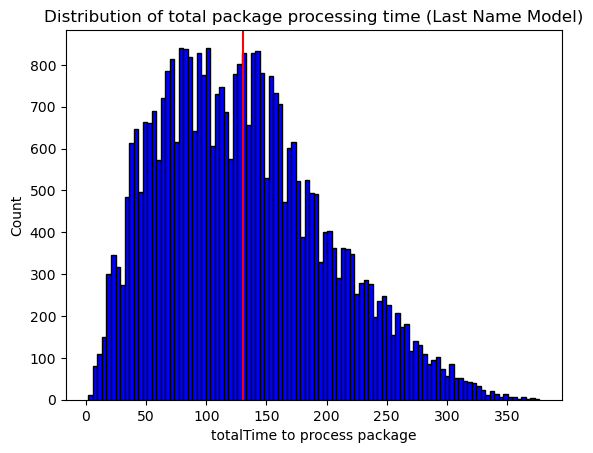

In [33]:
plt.hist(ln_package_df['totalTime'], color = 'blue', edgecolor = 'black',
         bins = 100)
plt.axvline(ln_package_df['totalTime'].mean(), color = 'r')
plt.xlabel("totalTime to process package")
plt.ylabel("Count")
plt.title("Distribution of total package processing time (Last Name Model)")
plt.show()
# plt.bar(package_df['day'], package_df['rackTime'])
# plt.bar(package_df['day'], package_df['findTime'])

## hash sim

In [25]:
def runHashSim(packagesize_dist, lastname_dist, num_bins, arrival_counts_edited, pickup_dist, days):
    # for now, packagesize_dist is not implemented.

    #setup bins
    all_bins = [] #to store all the bins of this simulation
    for i in range(num_bins):
        all_bins.append(Bin(str(i)))
    
    all_packages = [] #to store all the packages of this simulation
    all_students = [] #to store all the students of this simulation
    counter_packages = 0 # for packageID purposes
    counter_students = 0 #for studentID purposes

    #VARIBLES WE WANT TO TRACK IN THE SIMULATION WILL GO IN THIS:
    df = pd.DataFrame(columns=['day', 'studentID', 'packageID', 'rackTime', 'findTime', 'totalTime', 'days_to_pickup'])
    df_total_packages = pd.DataFrame(columns = ['day', 'num_packages', 'packages_expired'])

    for d in range(days):
        # print("day ", d)
        num_packages=  arrival_counts_edited.loc[d]['count']
        for i in range(num_packages):
            #randomly get the lastnameletter from the distribution 
            letter = select_lastname_based_on_distribution(lastname_dist)

            #make the student 
            all_students.append(Student(counter_students, letter))
            counter_students= counter_students + 1 #increase counter, so that the next student has a unique id 


            #determine which bin it goes in
            bin_to_go_in = counter_packages%num_bins
            initial_bin_to_go_in = bin_to_go_in
            while(len(all_bins[bin_to_go_in].getPackages()) > 300):
                 bin_to_go_in = (bin_to_go_in+1)%num_bins
                 if bin_to_go_in == initial_bin_to_go_in:
                      raise(Exception("NOOOOOOO"))
    
            #finally, make the package object
            package = (Package(counter_packages, bin_to_go_in, all_bins[bin_to_go_in].getNumPackages(), 'small', all_students[i]))
            all_packages.append(package)
            counter_packages= counter_packages + 1 #increase counter, so that the next package has a unique id 
            
            #update the bin so it knows it has a new package
            all_bins[bin_to_go_in].addPackage(package)

        #print where the packages were assigned to!
        # for p in all_packages:
        #     print(p)

        # for s in all_students:
        #     print(s)
                
        # --------------------------------------------------------------------------
        #BEGIN THE SIMULATION
        
        # there is some probability that a student comes to pick up their package today 
        
        # GEOMETRIC VERSION 
        # packages_picked_up_today = []
        # for package in all_packages:
        #     randomvar = random.random()
        #     if (randomvar <= ((1-geo_prob)**(package.getDaysOnShelf()-1))*geo_prob):
        #         packages_picked_up_today.append(package)

        # DISTRIBUTION VERSION
        packages_picked_up_today = []
        for package in all_packages:
            randomvar = random.random()
            prob_of_pickup = pickup_dist.loc[package.getDaysOnShelf()]['count']
            if (randomvar <= prob_of_pickup):
                packages_picked_up_today.append(package)

        #shuffle the packages being picked up today 
        random.shuffle(packages_picked_up_today)
            
        #now process the packages in this order
        for p in packages_picked_up_today:

            df.loc[len(df.index)] = [d, p.getStudent().getID(), p.getID(), p.getBin()+1, p.getLocation()+1, 
                                             p.getBin()+p.getLocation()+2, p.getDaysOnShelf()]
            
            #remove the package from the bin and adjust location in bin info
            all_bins[p.getBin()].removePackage(p)
            all_packages.remove(p)


            #adjust bin info for packages still in that bin, ONLY IF the package has a higher location_in_bin value than the removed package.
            for package in all_bins[p.getBin()].getPackages():
                if p.getLocation()<package.getLocation():
                        package.setLocation(package.getLocation()-1)

            #also remove the student -- by not doing this, all_students is now a list of just all students, not those with packages
            # print(p, p.getStudent())
            # all_students.remove(p.getStudent())
                

        #at the end of the day, increase the days_on_shelf counter for all leftover packages
        thrown_out_counter = 0;
        for p in all_packages: 
            p.addDay()
            #if the package has been there for over 2 weeks, remove it from the simulation
            if(p.getDaysOnShelf()>7):
                thrown_out_counter = thrown_out_counter+1
                all_bins[p.getBin()].removePackage(p)
                all_packages.remove(p)
                for package in all_bins[p.getBin()].getPackages():
                    if p.getLocation()<package.getLocation():
                            package.setLocation(package.getLocation()-1)


        #after we process everything for the day, save how many packages there are at the end of the day
        # df_total_packages .loc= pd.Dataframe(columns = ['day', 'num_packages'])
        df_total_packages.loc[len(df_total_packages.index)] = [d, len(all_packages), thrown_out_counter]


        # print(df)
        # print(df_total_packages)
    return df, df_total_packages



In [26]:
num_days = 91
package_df, day_df = runHashSim('test', lastname_distribution, 26, arrival_counts_edited, pickup_dist, num_days)

In [27]:
print(package_df[['rackTime', 'findTime', 'totalTime', 'days_to_pickup']].mean())
print("avg number of packages at end of day:", day_df['num_packages'].mean())
print("total number of packages thrown out within the ", num_days, "simulation: ",  day_df['packages_expired'].sum())

rackTime          13.516159
findTime          76.312331
totalTime         89.828490
days_to_pickup     0.751076
dtype: float64
avg number of packages at end of day: 1797.7582417582419
total number of packages thrown out within the  91 simulation:  15799


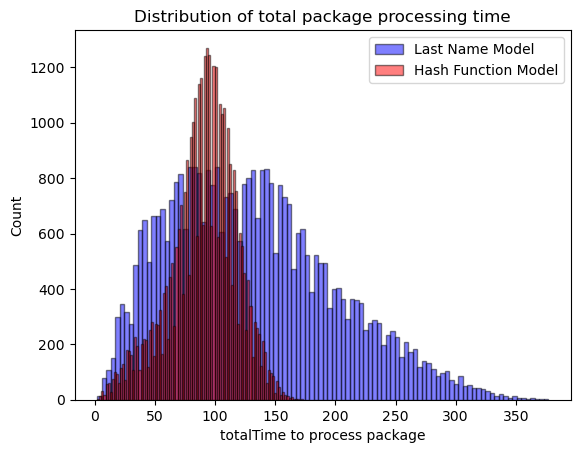

In [39]:
plt.hist(ln_package_df['totalTime'], color = 'blue', edgecolor = 'black',
         bins = 100, alpha = 0.5)
plt.hist(package_df['totalTime'], color = 'red', edgecolor = 'black',
         bins = 100, alpha = 0.5)
plt.xlabel("totalTime to process package")
plt.ylabel("Count")
plt.title("Distribution of total package processing time")
plt.legend(["Last Name Model", "Hash Function Model"], loc="upper right")
plt.show()

In [48]:
day_df

,day,num_packages,packages_expired
0,0,53,0
1,1,61,0
2,2,96,0
3,3,124,0
4,4,137,0
...,...,...,...
86,86,2359,242
87,87,2394,251
88,88,2298,249
89,89,2191,279


In [47]:
plt.hist(ln_day_df['packages_expired'], color = 'blue', edgecolor = 'black',
         bins = 100)
plt.hist(day_df['packages_expired'], color = 'red', edgecolor = 'black',
         bins = 100)
plt.xlabel("totalTime to process package")
plt.ylabel("Count")
plt.title("Distribution of total package processing time (Last Name Model)")
plt.show()

130.54369396930116

In [ ]:
def runAmberSim(num_bins, arrival_prob, students, days):
    
    #setup bins
    all_bins = [] #to store all the bins of this simulation
    #splits the alphabet into bins
    alpha_bin_names = np.array_split(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'), num_bins)
    #creates bins based on alphabet
    for name in alpha_bin_names:
       all_bins.append(Bin(str(name)))
    
    all_packages = [] #to store all the packages of this simulation
    counter = 0 # for packageID purposes

    #VARIBLES WE WANT TO TRACK IN THE SIMULATION WILL GO IN THIS:
    df = pd.DataFrame(columns=['day', 'studentID', 'packageID', 'rackTime', 'findTime', 'totalTime'])
    
    for d in range(days):
        # print("day ", d)
        for student in students: #one package per student!
            #determine which bin it goes in
            for j in range(num_bins):
                if student.getLetter() in alpha_bin_names[j]:
                    bin_to_go_in = j #this returns the bin's index number in the all_bins list 
    
            #finally, make the package object
            package = (Package(counter, bin_to_go_in, all_bins[bin_to_go_in].getNumPackages(), 'small', student))
            all_packages.append(package)
            
            #update the bin so it knows it has a new package
            all_bins[bin_to_go_in].addPackage(package)
    
            counter = counter+1
    
        #print where the packages were assigned to!
        # for p in all_packages:
        #     print(p)

        #BEGIN THE SIMULATION
        
        # there is some probability that a student comes to pick up their package today 
        students_arriving_today = []
        for student in students:
            randomvar = random.random()
            if (randomvar <= arrival_prob):
                students_arriving_today.append(student)

        #shuffle the students arriving today 
        random.shuffle(students_arriving_today)

        #now process the students in this order
        for student in students_arriving_today:

            #make a list of all the packages this student has in the mailroom as of today
            student_packages = []
            for p in all_packages:
                if(p.getStudent()==student):
                    student_packages.append(p)

            first_package_checker = True
            for student_p in student_packages:
                #update the df with how long it took to get the package
                # add one second for rackTime and findTime so that it doesn't take 0 seconds
                if(first_package_checker):
                    df.loc[len(df.index)] = [d, student.getID(), student_p.getID(), student_p.getBin()+1, student_p.getLocation()+1, 
                                             student_p.getBin()+student_p.getLocation()+2]
                    first_package_checker = False
                else: #multiple packages, don't need to walk to any other bin (since bins are based on last name)
                    df.loc[len(df.index)] = [d, student.getID(), student_p.getID(), 0, student_p.getLocation()+1, student_p.getLocation()+1]
                
                #remove the package from the bin and adjust location in bin info
                # print(all_bins[student_p.getBin()].packages)
                all_bins[student_p.getBin()].removePackage(student_p)
                all_packages.remove(student_p)

                #adjust bin info for packages still in that bin, ONLY IF the package has a higher location_in_bin value than the removed package.
                for package in all_bins[student_p.getBin()].getPackages():
                    if student_p.getLocation()<package.getLocation():
                        package.setLocation(package.getLocation()-1)
        print(df)
    return df


In [ ]:
#we decided to manually make 5 students per Amber's suggestion
students_list = []
students_list.append(Student(0, 'A'))
students_list.append(Student(1, 'A'))
students_list.append(Student(2, 'L'))
students_list.append(Student(3, 'L'))
students_list.append(Student(4, 'Z'))

# runAmberSim(num_bins, arrival_prob, students, days):
output_df = runAmberSim(10, 0.5, students_list, 7)

   day  studentID  packageID  rackTime  findTime  totalTime
0    0          4          4        10         1         11
1    0          3          3         4         2          6
   day  studentID  packageID  rackTime  findTime  totalTime
0    0          4          4        10         1         11
1    0          3          3         4         2          6
2    1          1          1         1         2          3
3    1          1          6         0         3          3
4    1          0          0         1         1          2
5    1          0          5         0         1          1
6    1          3          8         4         3          7
7    1          2          2         4         1          5
8    1          2          7         0         1          1
    day  studentID  packageID  rackTime  findTime  totalTime
0     0          4          4        10         1         11
1     0          3          3         4         2          6
2     1          1          1        

In [ ]:
output_df

,day,studentID,packageID,rackTime,findTime,totalTime
0,0,1,1,1,2,3
1,0,2,2,4,1,5
2,1,1,6,1,3,4
3,1,2,7,4,2,6
4,2,3,3,4,1,5
5,2,3,8,0,1,1
6,2,3,13,0,2,2
7,2,2,12,4,1,5
8,2,4,4,10,1,11
9,2,4,9,0,1,1


In [ ]:
output_df.mean()

day           2.964286
studentID     2.107143
packageID    14.250000
rackTime      2.428571
findTime      1.464286
totalTime     3.892857
dtype: float64

In [ ]:
output_df.median()

day           2.0
studentID     2.0
packageID    13.5
rackTime      1.0
findTime      1.0
totalTime     3.0
dtype: float64